# Configuración

## Librerias

In [63]:
'''
!pip3 install numpy
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install numpy
'''

'\n!pip3 install numpy\n!pip3 install matplotlib\n!pip3 install tensorflow\n!pip3 install numpy\n'

In [64]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from mtcnn import MTCNN

## Constantes

In [65]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

# Preprocesamiento

## Funciones

In [66]:
def preprocess_image(input_path, output_path, target_resolution=IMG_SIZE):

    try:
        # Load the image
        img = cv2.imread(input_path)

        try:
            img_corrected = np.power(img / 255.0, 1.5) * 255.0
        except Exception as e:
            print(f'Image {img} could not be gamma corrected due to    {e}' )

        try:
            img_contrast = cv2.convertScaleAbs(img_corrected, alpha=1.2, beta=0)
        except Exception as e:
            print(f'Image {img} could not be contrast corrected due to {e}' )

        try:
            img_resized = cv2.resize(img_contrast, target_resolution)
        except Exception as e:
            print(f'Image {img} could not be resized due to            {e}' )


        cv2.imwrite(output_path, img_resized)

    except:
        print(f'Image on {input_path} could not be loaded' )



def preprocess_images_in_directory(src_directory, dest_directory):
    # Iterate through train and validation directories
    for type in os.listdir(src_directory):
        dataset_path = os.path.join(src_directory, type)

        # Skip non-directory entries
        if not os.path.isdir(dataset_path):
            continue

        # Create corresponding directory in the destination
        dest_dataset_path = os.path.join(dest_directory, type)
        os.makedirs(dest_dataset_path, exist_ok=True)

        # Iterate through each season in the dataset
        for season in os.listdir(dataset_path):
            season_path = os.path.join(dataset_path, season)

            # Skip non-directory entries
            if not os.path.isdir(season_path):
                continue

            # Create a corresponding subdirectory in the destination directory
            dest_season_path = os.path.join(dest_dataset_path, season)
            os.makedirs(dest_season_path, exist_ok=True)

            # Iterate through each image in the season directory
            for filename in os.listdir(season_path):
                if filename.endswith(('.jpeg', '.jpg', '.png')):
                    input_path = os.path.join(season_path, filename)

                    # Generate the output path in the destination directory
                    output_path = os.path.join(dest_season_path, filename)

                    # Preprocess and save the image
                    print(f'Will now preprocess image on {type}/{season}/{filename}')
                    preprocess_image(input_path, output_path)

## Ejecucion

In [67]:
src_directory = "./static/images/estaciones_filtered"  # Adjust this to your input folder
dest_directory = "./static/images/estaciones_preprocessed"  # Adjust this to your output folder

In [68]:
preprocess_images_in_directory(src_directory, dest_directory)

Will now preprocess image on validation/Otoño/Otono007.jpg
Will now preprocess image on validation/Otoño/Otono008.jpg
Will now preprocess image on validation/Otoño/Otono001.jpeg
Will now preprocess image on validation/Otoño/Otono003.jpg
Will now preprocess image on validation/Otoño/Otono002.jpeg
Will now preprocess image on validation/Otoño/Otono005.jpg
Will now preprocess image on validation/Otoño/Otono004.jpg
Will now preprocess image on validation/Otoño/Otono006.jpg
Will now preprocess image on validation/Verano/Verano001.jpeg
Will now preprocess image on validation/Verano/Verano004.jpg
Will now preprocess image on validation/Verano/Verano007.jpg
Will now preprocess image on validation/Verano/Verano002.jpeg
Will now preprocess image on validation/Verano/Verano003.jpg
Will now preprocess image on validation/Verano/Verano008.jpg
Will now preprocess image on validation/Verano/Verano006.jpg
Will now preprocess image on validation/Verano/Verano005.jpg
Will now preprocess image on validat

# Modelo

## Datasets desde folder

In [ ]:
PATH ='/work/Proyecto-IA-2023/static/images/estaciones_preprocessed/'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
                                                        train_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

In [ ]:
testing_dataset = tf.keras.utils.image_dataset_from_directory(
                                                        validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

## Cardinalidad

In [ ]:
val_batches = tf.data.experimental.cardinality(train_dataset)
print(f'Number of batches: {val_batches}')

Number of batches: 2


In [ ]:
val_batches = tf.data.experimental.cardinality(testing_dataset)
print(f'Number of batches: {val_batches}')

Number of batches: 3


## División en validación y pruebas

In [ ]:
test_dataset = testing_dataset.take(val_batches // 5)
validation_dataset = testing_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 0


# Modelo

## Datasets desde folder

2023-11-13 19:49:04.532676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 39 of 256
2023-11-13 19:49:08.810663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


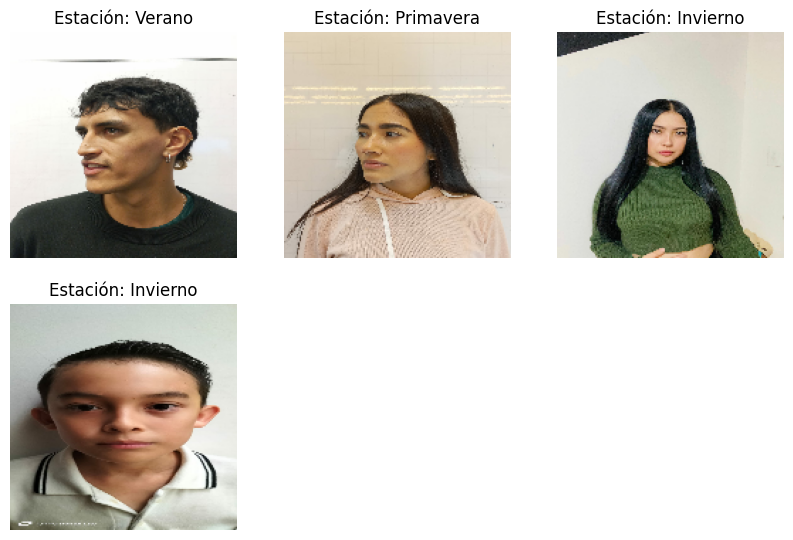

In [ ]:
def estaciones(codigo):
    if (codigo == [0., 0., 1., 0.]).all():
        return 'Primavera'
    elif (codigo == [0., 1., 0., 0.]).all():
        return 'Verano'
    elif (codigo == [0., 0., 0., 1.]).all():
        return 'Otoño'
    elif (codigo == [1., 0., 0., 0.]).all():
        return 'Invierno'

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    estacion_codigo = estaciones(labels[i].numpy())
    plt.title(f'Estación: {estacion_codigo}')

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomBrightness([-0.4,0.4]),
  tf.keras.layers.RandomZoom(height_factor=(-0.05, 0.2) ),
])

2023-11-13 19:49:19.847348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15 of 256
2023-11-13 19:49:30.241760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 26 of 256
2023-11-13 19:49:40.731667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 38 of 256
2023-11-13 19:49:50.645687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 51 of 256
(160, 160, 3)
2023-11-13 19:49:54.872750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


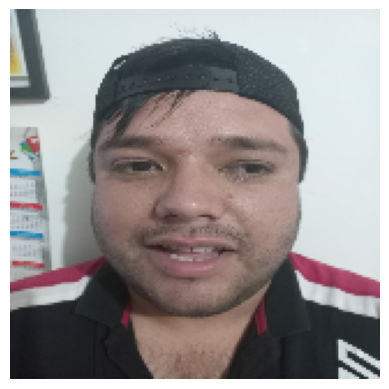

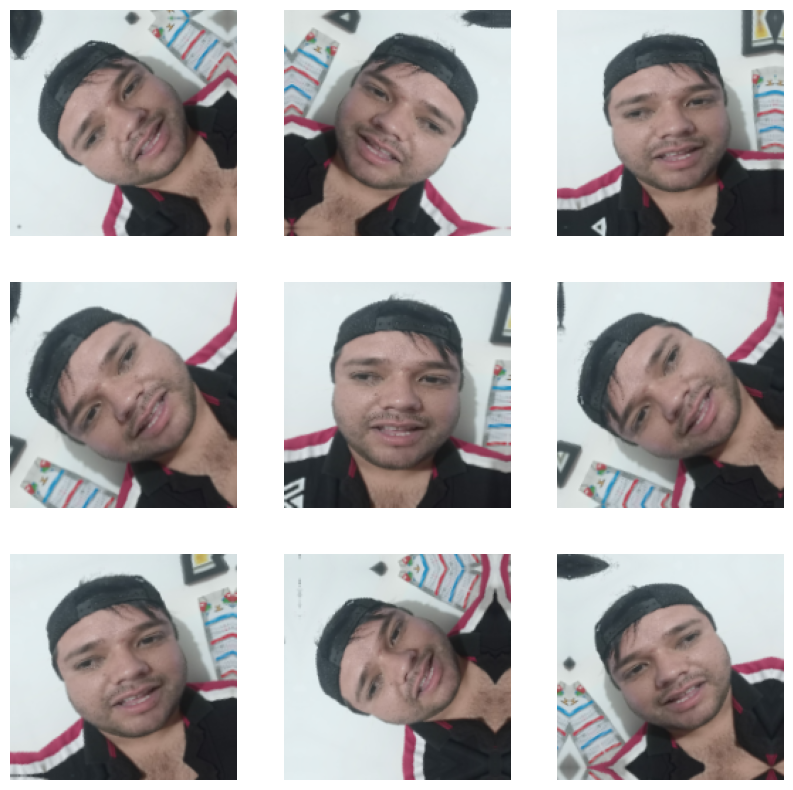

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure()
  first_image = image[0]
  plt.imshow(first_image / 255)
  plt.axis('off')
  print(first_image.shape)
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
print(base_model.summary())
#tf.keras.utils.plot_model(base_model, to_file='model.png')

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
tf.keras.utils.plot_model(base_model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-11-13 19:50:17.135311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9 of 256
2023-11-13 19:50:27.736988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 23 of 256
2023-11-13 19:50:39.466130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 35 of 256
2023-11-13 19:50:46.842797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 45 of 256
2023-11-13 19:50:56.990789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 56 of 256
2023-11-13 19:50:57.574478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
(32, 5, 5, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2023-11-13 19:51:10.068030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 24 of 256
2023-11-13 19:51:20.235575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 61 of 256
2023-11-13 19:51:28.556713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
3/3 [==============================] - 31s 497ms/step - loss: 0.7579 - accuracy: 0.2000
initial loss: 0.76
initial accuracy: 0.20


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
2023-11-13 19:51:44.879068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9 of 256
2023-11-13 19:51:54.134936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 21 of 256
2023-11-13 19:52:04.060483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 34 of 256
2023-11-13 19:52:14.041255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 45 of 256
2023-11-13 19:52:24.039724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 57 of 256
2023-11-13 19:52:24.472538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2/2 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.2333 2023-11-13 19:52:35.746026: I tensorflow/core/kernels/data/shuffl

Text(0.5, 1.0, 'Training and Validation Accuracy')

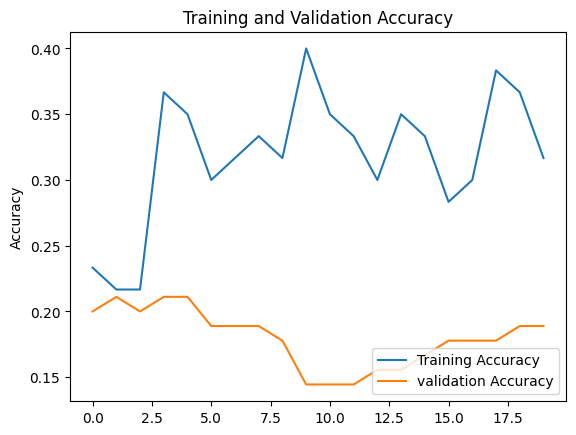

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')


In [ ]:
model.save('final_model.h5')

In [ ]:
base_model.trainable = True

capas_bloqueadas =len(base_model.layers)- 10

for layer in base_model.layers[:capas_bloqueadas]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124  

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
2023-11-13 20:28:13.036245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9 of 256
2023-11-13 20:28:23.639321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 19 of 256
2023-11-13 20:28:33.561460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 31 of 256
2023-11-13 20:28:43.948207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 44 of 256
2023-11-13 20:28:55.475904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 56 of 256
2023-11-13 20:28:55.681182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2/2 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.3333 2023-11-13 20:29:10.031435: I tensorflow/core/kernels/data/shuff

In [1]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

NameError: name 'plt' is not defined

In [ ]:
model.save('final_model.h5')

Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Labels:
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


TypeError: ignored

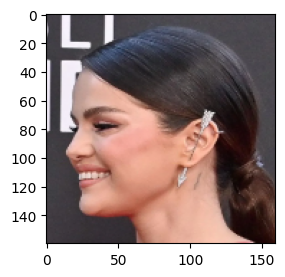

StopIteration: 

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(14, 28))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f' p:{class_names[predictions[i]]}, l:{class_names[label_batch[i]]}')
  plt.axis("off")

In [ ]:
!pip install gradio==3.45.0

ERROR: Invalid requirement: '=='


In [ ]:

import tensorflow as tf

import gradio as gr

inception_net = tf.keras.models.load_model('final_model.h5')

labels = ['gato','perro']
def classify_image(inp):
    inp = inp.reshape((-1, 160, 160, 3))
    prediction = inception_net.predict(inp).flatten()
    prediction = tf.nn.sigmoid(prediction)
    prediction = tf.where(prediction < 0.5, 0, 1)
    return labels[int(prediction)]

image = gr.inputs.Image(shape=(160, 160), source="upload")
label = gr.outputs.Label()

gr.Interface(
    fn=classify_image, inputs=image, outputs=label, interpretation="default"
).launch(debug=True)

ModuleNotFoundError: ignored

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99412c2e-f061-48b1-b330-0dfd48ccdcce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>